In [9]:
# Imports
import math, argparse
import numpy as np
import pandas as pd
from numpy.random.mtrand import sample
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr,GPDC, CMIknn, CMIsymb
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.Granger.Granger import Granger
from matplotlib import pyplot as plt
import sys
sys.path.append("")
from multiprocessing import Pool
import igraph as ig
import random
from causalnex.structure.dynotears import from_pandas_dynamic
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Image



In [13]:
data_all = pd.read_csv("20230222_COPD_TTTF.csv")
# data_all = data_all.loc[:, ["copd","temp","rh","co","o3h8max","fsp","so2","no2"]]
# data_all.rename(columns={'copd': "COPD",
#                            'co': 'CO',
#                           'o3h8max': 'O3',
#                           'fsp': 'PM2.5',
#                           'so2': 'SO2',
#                           'no2': 'NO2',
#                          'temp': 'Temp',
#                          'rh': 'Humid'}, inplace=True)

data_all = data_all.loc[:, ["copd","temp","rh","o3h8max","co","fsp","no2"]]
data_all.rename(columns={'copd': "COPD",
                          'o3h8max': 'O3',
                          'fsp': 'PM2.5',
                          'no2': 'NO2',
                         'co': 'CO',
                         'temp': 'Temp',
                         'rh': 'Humid'}, inplace=True)
df = data_all.to_numpy()

data_all


,COPD,Temp,Humid,O3,CO,PM2.5,NO2
0,-1.010596,-2.457233,-2.247166,0.417638,-1.140999,-0.904420,-0.962292
1,1.234510,-1.369281,-1.048869,-0.488614,0.323436,-0.287935,0.070952
2,1.720153,-0.166181,-0.377096,-0.937877,2.364566,1.392789,2.423914
3,-0.063193,0.234852,-1.248585,-1.002708,5.516282,3.216421,2.576090
4,-0.063193,0.290441,0.376378,0.136555,1.088011,1.058571,-0.029372
...,...,...,...,...,...,...,...
4378,-1.192836,-0.255334,-1.365508,-0.021658,-0.471429,-1.466340,-1.646360
4379,-0.555926,-1.323433,-1.138558,-0.458266,-1.408410,-0.301826,-0.794233
4380,-0.601444,0.222061,-1.077388,-0.044597,0.442751,0.136988,-0.439166
4381,-2.655477,0.357062,-0.314836,-0.621602,-0.496866,0.028435,-0.077963


In [32]:

g_learnt,w,a = from_pandas_dynamic(data_all,p=6,lambda_w=0.1,lambda_a=0.1,w_threshold=0.00)


In [33]:
g_learnt.adj

AdjacencyView({'COPD_lag0': {}, 'COPD_lag1': {'COPD_lag0': {'origin': 'learned', 'weight': 0.1475001621756324}}, 'COPD_lag2': {'COPD_lag0': {'origin': 'learned', 'weight': 0.11164127386980995}}, 'COPD_lag3': {'COPD_lag0': {'origin': 'learned', 'weight': 0.10714902919554467}}, 'COPD_lag4': {'COPD_lag0': {'origin': 'learned', 'weight': 0.08346875664224583}}, 'COPD_lag5': {'COPD_lag0': {'origin': 'learned', 'weight': 0.038825501417906576}}, 'COPD_lag6': {'COPD_lag0': {'origin': 'learned', 'weight': 0.048270922292751865}}, 'Temp_lag0': {}, 'Temp_lag1': {'Temp_lag0': {'origin': 'learned', 'weight': 0.6821028843778639}}, 'Temp_lag2': {'COPD_lag0': {'origin': 'learned', 'weight': -0.04142820504847845}, 'NO2_lag0': {'origin': 'learned', 'weight': -0.02978150273617831}}, 'Temp_lag3': {'COPD_lag0': {'origin': 'learned', 'weight': -0.0072964603680545715}}, 'Temp_lag4': {}, 'Temp_lag5': {}, 'Temp_lag6': {}, 'Humid_lag0': {'O3_lag0': {'origin': 'learned', 'weight': -0.20844481212799845}, 'PM2.5_lag

In [34]:
pd.DataFrame(g_learnt.edges)

,0,1
0,COPD_lag1,COPD_lag0
1,COPD_lag2,COPD_lag0
2,COPD_lag3,COPD_lag0
3,COPD_lag4,COPD_lag0
4,COPD_lag5,COPD_lag0
5,COPD_lag6,COPD_lag0
6,Temp_lag1,Temp_lag0
7,Temp_lag2,COPD_lag0
8,Temp_lag2,NO2_lag0
9,Temp_lag3,COPD_lag0


In [36]:
pd.DataFrame(g_learnt.edges(data="weight"))

,0,1,2
0,COPD_lag1,COPD_lag0,0.147500
1,COPD_lag2,COPD_lag0,0.111641
2,COPD_lag3,COPD_lag0,0.107149
3,COPD_lag4,COPD_lag0,0.083469
4,COPD_lag5,COPD_lag0,0.038826
5,COPD_lag6,COPD_lag0,0.048271
6,Temp_lag1,Temp_lag0,0.682103
7,Temp_lag2,COPD_lag0,-0.041428
8,Temp_lag2,NO2_lag0,-0.029782
9,Temp_lag3,COPD_lag0,-0.007296


In [24]:
w

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.20844481,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.2575861 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.27495179,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.38461762],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [25]:
a

array([[0.14750016, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.68210288, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.62464548, 0.        , 0.        ,
        0.        , 0.        ],
       [0.05506684, 0.        , 0.        , 0.41258309, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.58720597,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.34883808, 0.        ],
       [0.        , 0.        , 0.        , 0.05714615, 0.        ,
        0.        , 0.27683632],
       [0.11164127, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0. 

In [18]:
w

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.08444812e-01,  0.00000000e+00, -8.50760365e-03,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -6.69495772e-05,
         0.00000000e+00,  0.00000000e+00,  2.57586103e-01,
         1.59957170e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.74951787e-01,
         3.65965979e-02],
       [ 0.00000000e+00,  0.00000000e+00, -2.89760144e-04,
         8.11544736e-05,  8.47233170e-05,  0.00000000e+00,
         3.84617623e-01],
       [ 0.00000000e+00,  3.65301517e-02,  0.00000000e+00,
         6.57045085e-04,  8.87544296e-04,  3.52718808e-05,
         0.0000000

In [16]:
a

array([[0.14750016, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.68210288, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.62464548, 0.        , 0.        ,
        0.        , 0.        ],
       [0.05506684, 0.        , 0.        , 0.41258309, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.58720597,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.34883808, 0.        ],
       [0.        , 0.        , 0.        , 0.05714615, 0.        ,
        0.        , 0.27683632],
       [0.11164127, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0. 

/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node 'COPD_lag4', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node 'COPD_lag4', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


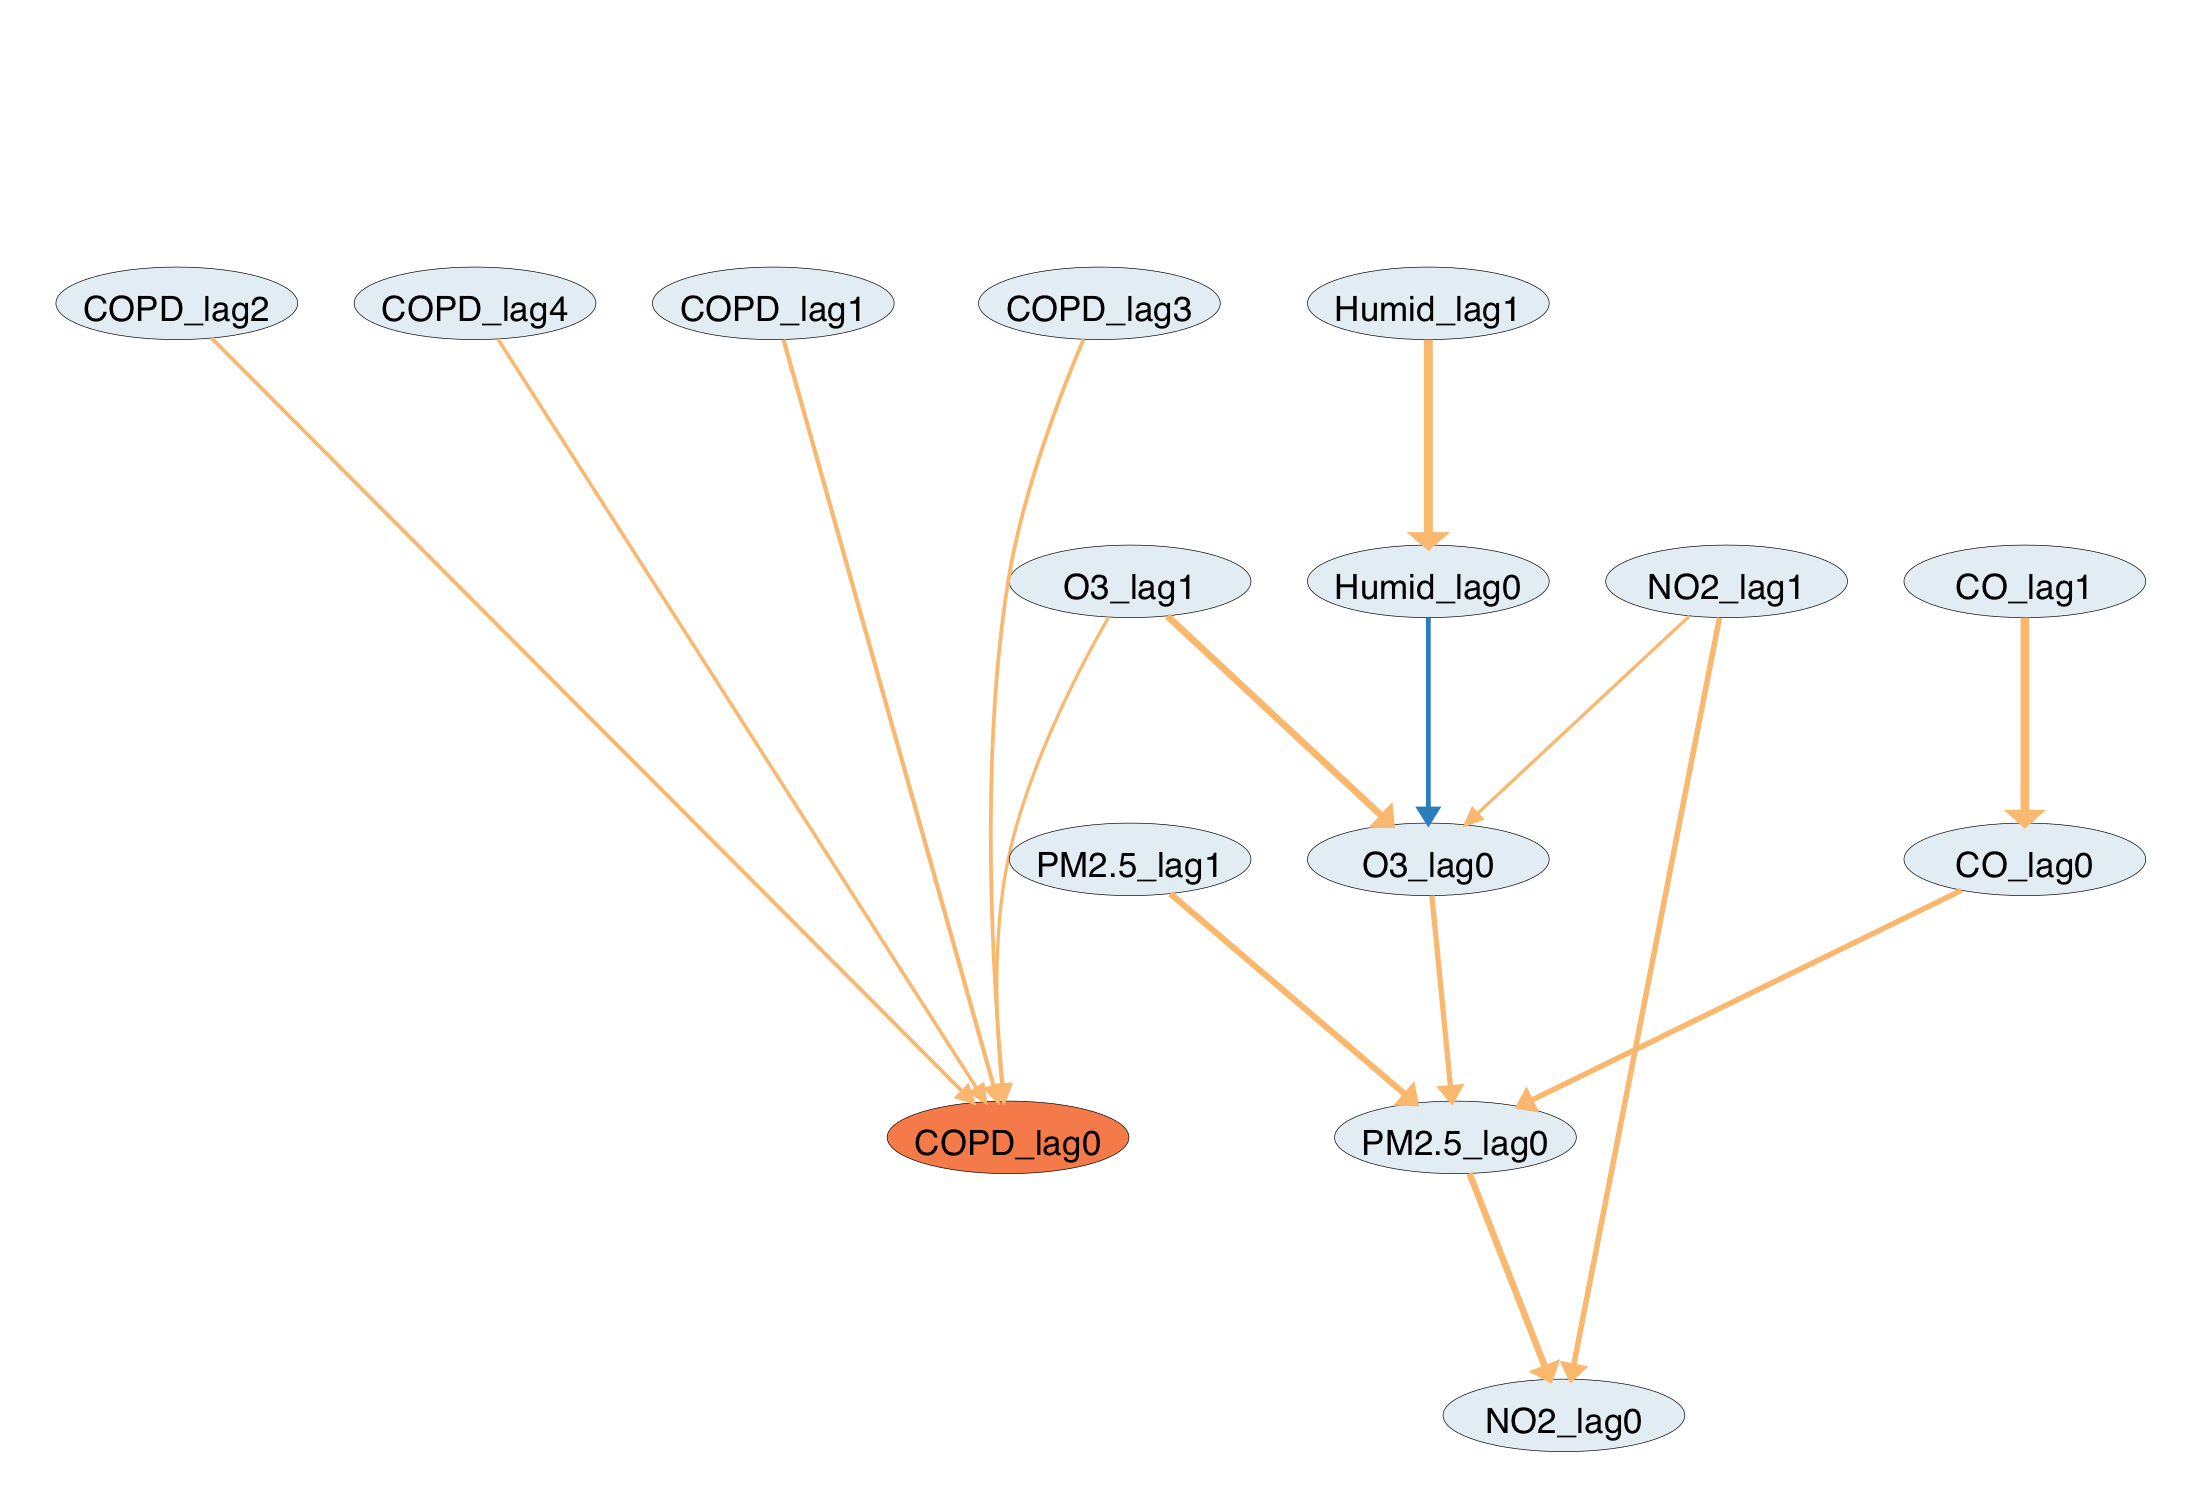

In [11]:

g_learnt,w,a = from_pandas_dynamic(data_all,p=6,lambda_w=0.1,lambda_a=0.1,w_threshold=0.05)

sm=g_learnt
graph_attributes = {
    "splines": "spline",  # I use splies so that we have no overlap
    "ordering": "out",
    "ratio": "fill",  # This is necessary to control the size of the image
#     "size": "4.5,2.5!",  # Set the size of the final image. (this is a typical presentation size)
    "size": "4.5,3!",
    "label": "The structure of our\n \t Insurance model",
    "fontcolor": "#FFFFFFD9",
    "fontname": "Helvetica",
    "fontsize": 100,
    "labeljust": "l",
    "labelloc": "t",
    "pad": "1,1",
    "dpi": 500,
    "nodesep": 0.8,
    "ranksep": ".5 equally",
    "bgcolor":"transparent",
}

# Making all nodes hexagonal with black coloring
node_attributes = {
    node: {
        "shape": "oval",
        "width": 5,
        "height": 1.5,
        "fillcolor": "#E1EDF3",##C9C0BB
        "penwidth": "1",
        "color": "#000000",
        "fontsize": 52,
        "labelloc": "t",
        "fontcolor": "#000000",
    }
    for node in sm.nodes
}

# # Splitting two words with "\n"
# for node in sm.nodes:
#     up_idx = [i for i, c in enumerate(node) if c.isupper()][-1]
#     node_attributes[node]["label"] = node[:up_idx] + "\n" + node[up_idx:]

# Target nodes (ones with "Cost" in the name) are colored differently
for node in sm.nodes:
    if "COPD_lag0" in node:  # We color nodes with "cost" in the name with a orange colour.
        node_attributes[node]["fillcolor"] = "#F57A49"#DF5F00

# Customising edges
edge_attributes = {
    (u, v): {
        "penwidth": abs(w) * 15 + 4,  # Setting edge thickness
        "weight": int(5 * abs(w)),  # Higher "weight"s mean shorter edges
        "arrowsize": 2.5 - 2.0 * abs(w),  # Avoid too large arrows
        "arrowtail": "dot",
        "color": "#F9B86D" #CF793A
    }
    for u, v, w in sm.edges(data="weight")
}

for u, v, w in sm.edges(data="weight"):
    if w<0:  # We color nodes with "cost" in the name with a orange colour.
        edge_attributes[(u, v)]["color"] = "#2A7EBC"





# Changing attributes of specific edges
# edge_attributes = {
#     ("Humid_lag0", "O3_lag0"): {"color": "blue"},

# }


viz = plot_structure(
    sm.get_largest_subgraph(),
    prog="dot",
    graph_attributes=graph_attributes,
    node_attributes=node_attributes,
    edge_attributes=edge_attributes,
)
# viz = plot_structure(
#     sm,
#     prog="dot",
#     graph_attributes=graph_attributes,
#     node_attributes=node_attributes,
#     edge_attributes=edge_attributes,
# )
# viz = plot_structure(
#     sm,
#     graph_attributes={"scale": "0.5"},
#     all_node_attributes=NODE_STYLE.WEAK,
#     all_edge_attributes=EDGE_STYLE.WEAK,
# )
Image(viz.draw(format='png'))


In [12]:
w

0.27683632205454844

In [7]:
g_learnt.edges
df=pd.DataFrame(g_learnt.edges)
col=df[1]


,0,1
0,COPD_lag1,COPD_lag0
1,COPD_lag2,COPD_lag0
2,COPD_lag3,COPD_lag0
3,COPD_lag4,COPD_lag0
4,Temp_lag1,Temp_lag0
5,Humid_lag0,O3_lag0
6,Humid_lag1,Humid_lag0
7,O3_lag0,PM2.5_lag0
8,O3_lag1,COPD_lag0
9,O3_lag1,O3_lag0


/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node 'Humid_lag3', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node 'Humid_lag3', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


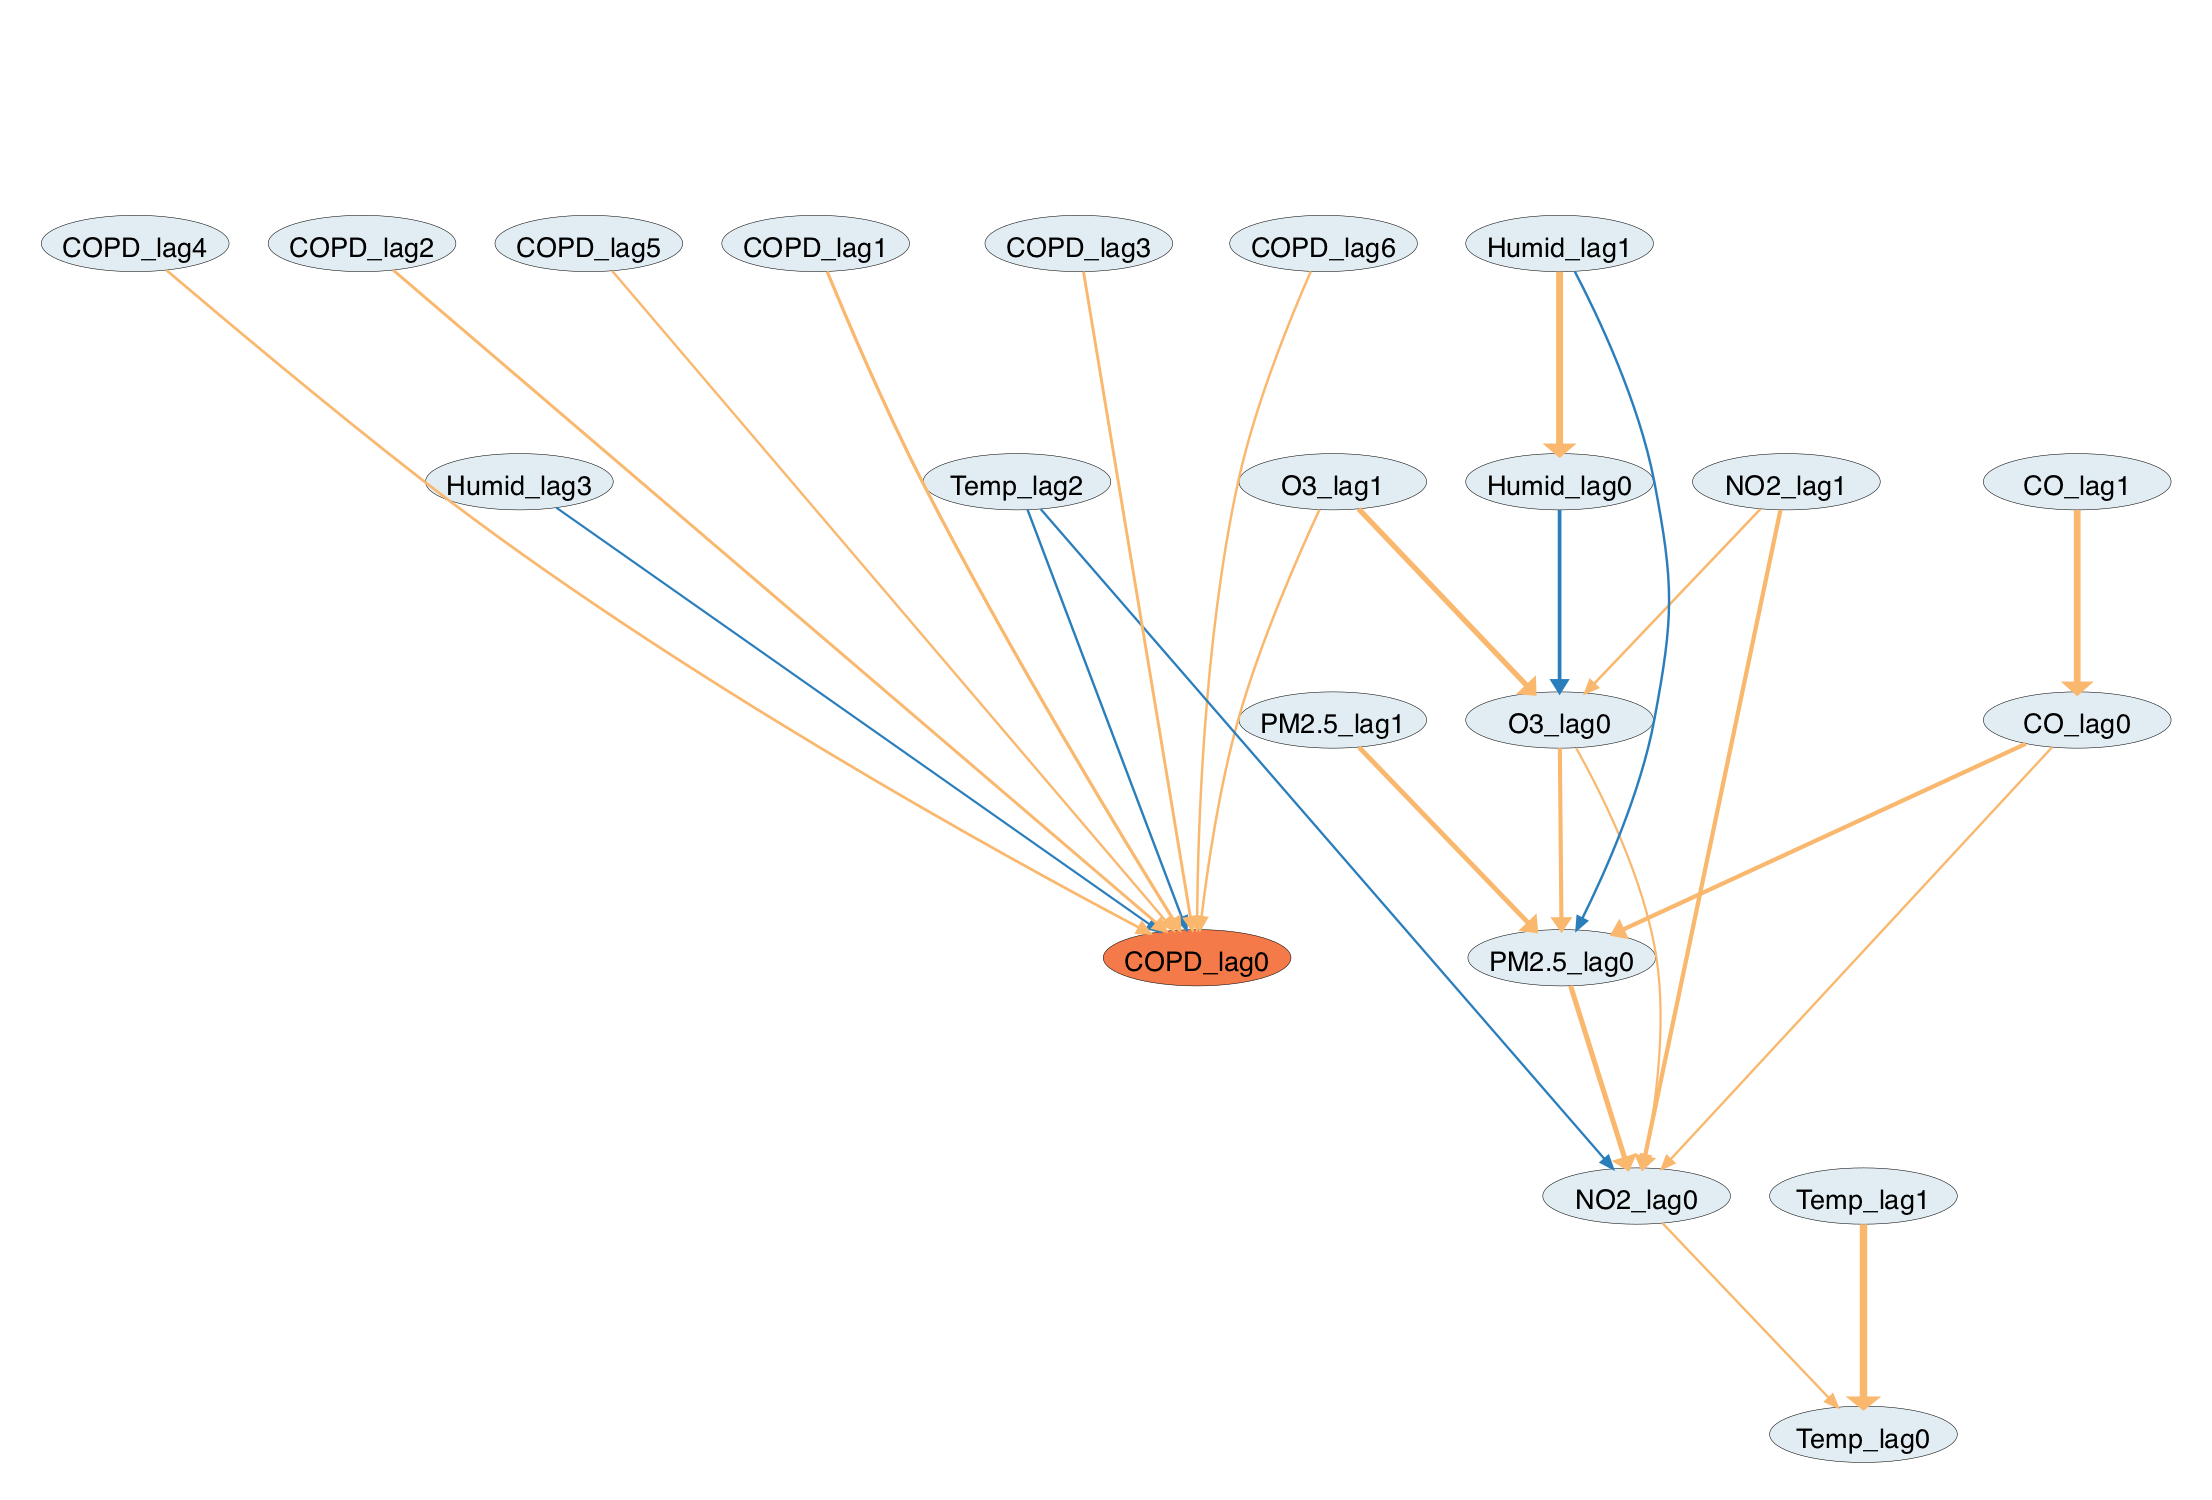

In [39]:

g_learnt,w,a = from_pandas_dynamic(data_all,p=6,lambda_w=0.1,lambda_a=0.1,w_threshold=0.01)

sm=g_learnt
graph_attributes = {
    "splines": "spline",  # I use splies so that we have no overlap
    "ordering": "out",
    "ratio": "fill",  # This is necessary to control the size of the image
#     "size": "4.5,2.5!",  # Set the size of the final image. (this is a typical presentation size)
    "size": "4.5,3!",
    "label": "The structure of our\n \t Insurance model",
    "fontcolor": "#FFFFFFD9",
    "fontname": "Helvetica",
    "fontsize": 100,
    "labeljust": "l",
    "labelloc": "t",
    "pad": "1,1",
    "dpi": 500,
    "nodesep": 0.8,
    "ranksep": ".5 equally",
    "bgcolor":"transparent",
}

# Making all nodes hexagonal with black coloring
node_attributes = {
    node: {
        "shape": "oval",
        "width": 5,
        "height": 1.5,
        "fillcolor": "#E1EDF3",##C9C0BB
        "penwidth": "1",
        "color": "#000000",
        "fontsize": 52,
        "labelloc": "t",
        "fontcolor": "#000000",
    }
    for node in sm.nodes
}

# # Splitting two words with "\n"
# for node in sm.nodes:
#     up_idx = [i for i, c in enumerate(node) if c.isupper()][-1]
#     node_attributes[node]["label"] = node[:up_idx] + "\n" + node[up_idx:]

# Target nodes (ones with "Cost" in the name) are colored differently
for node in sm.nodes:
    if "COPD_lag0" in node:  # We color nodes with "cost" in the name with a orange colour.
        node_attributes[node]["fillcolor"] = "#F57A49"#DF5F00

# Customising edges
edge_attributes = {
    (u, v): {
        "penwidth": abs(w) * 15 + 4,  # Setting edge thickness
        "weight": int(5 * abs(w)),  # Higher "weight"s mean shorter edges
        "arrowsize": 2.5 - 2.0 * abs(w),  # Avoid too large arrows
        "arrowtail": "dot",
        "color": "#F9B86D" #CF793A
    }
    for u, v, w in sm.edges(data="weight")
}

for u, v, w in sm.edges(data="weight"):
    if w<0:  # We color nodes with "cost" in the name with a orange colour.
        edge_attributes[(u, v)]["color"] = "#2A7EBC"





# Changing attributes of specific edges
# edge_attributes = {
#     ("Humid_lag0", "O3_lag0"): {"color": "blue"},

# }


viz = plot_structure(
    sm.get_largest_subgraph(),
    prog="dot",
    graph_attributes=graph_attributes,
    node_attributes=node_attributes,
    edge_attributes=edge_attributes,
)
# viz = plot_structure(
#     sm,
#     prog="dot",
#     graph_attributes=graph_attributes,
#     node_attributes=node_attributes,
#     edge_attributes=edge_attributes,
# )
# viz = plot_structure(
#     sm,
#     graph_attributes={"scale": "0.5"},
#     all_node_attributes=NODE_STYLE.WEAK,
#     all_edge_attributes=EDGE_STYLE.WEAK,
# )
Image(viz.draw(format='png'))


/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node 'COPD_lag0', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node 'COPD_lag0', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


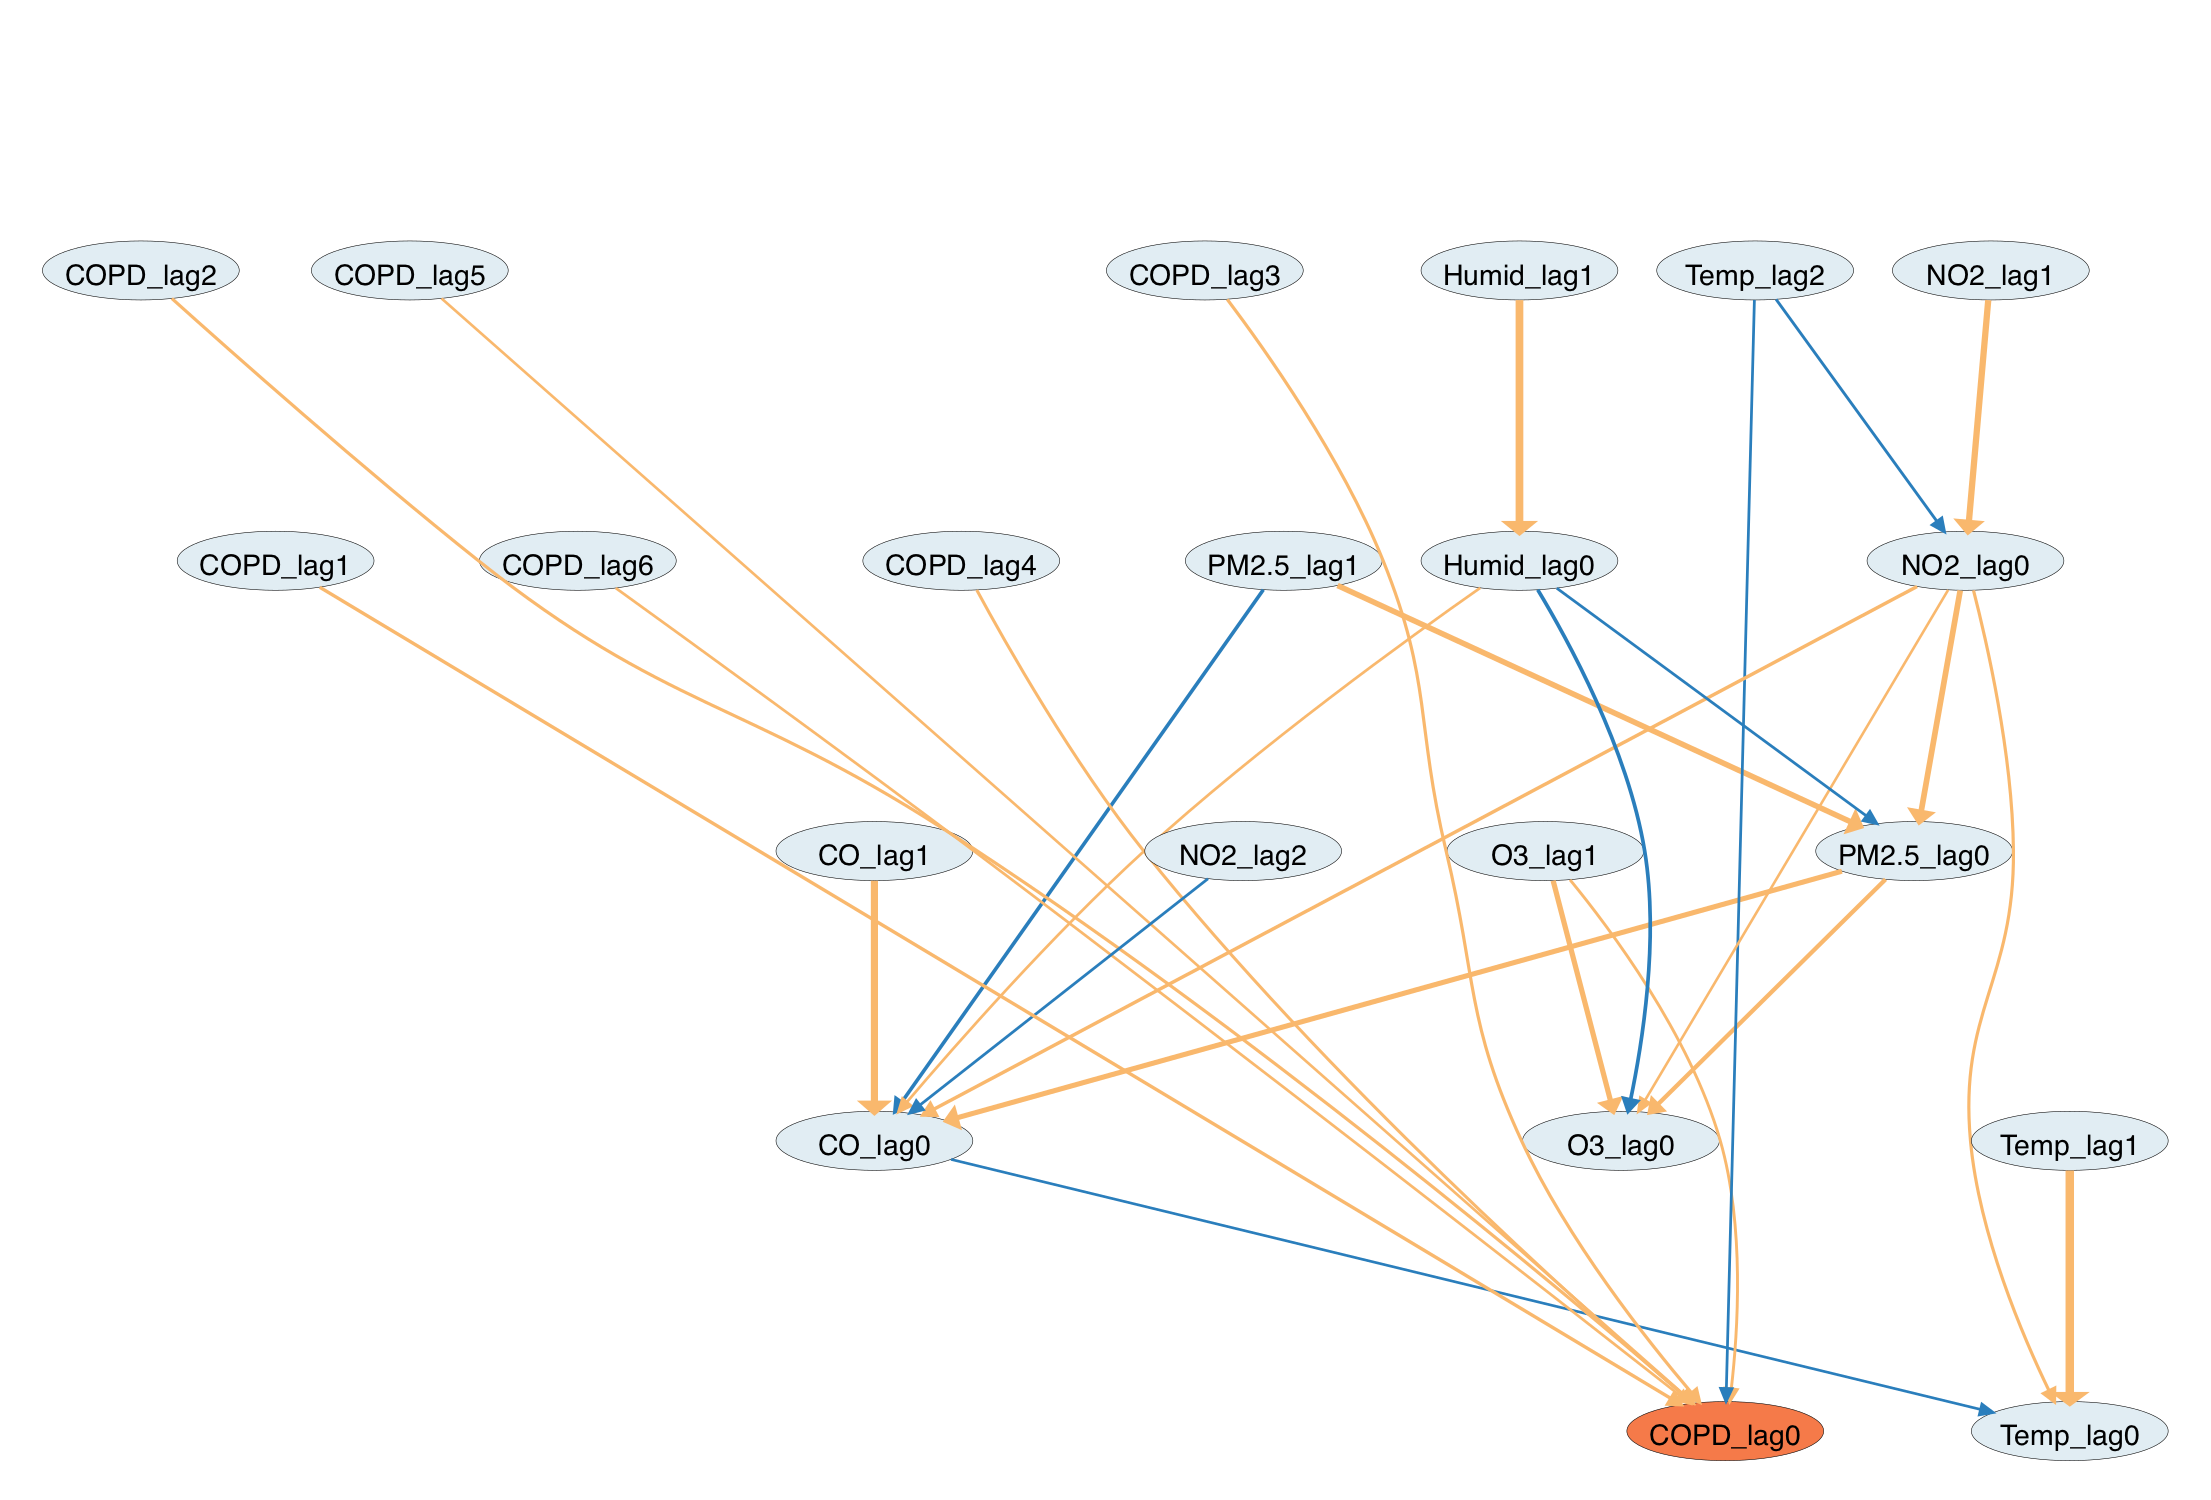

In [40]:

g_learnt,w,a = from_pandas_dynamic(data_all,p=6,lambda_w=0.05,lambda_a=0.05,w_threshold=0.05)

sm=g_learnt
graph_attributes = {
    "splines": "spline",  # I use splies so that we have no overlap
    "ordering": "out",
    "ratio": "fill",  # This is necessary to control the size of the image
#     "size": "4.5,2.5!",  # Set the size of the final image. (this is a typical presentation size)
    "size": "4.5,3!",
    "label": "The structure of our\n \t Insurance model",
    "fontcolor": "#FFFFFFD9",
    "fontname": "Helvetica",
    "fontsize": 100,
    "labeljust": "l",
    "labelloc": "t",
    "pad": "1,1",
    "dpi": 500,
    "nodesep": 0.8,
    "ranksep": ".5 equally",
    "bgcolor":"transparent",
}

# Making all nodes hexagonal with black coloring
node_attributes = {
    node: {
        "shape": "oval",
        "width": 5,
        "height": 1.5,
        "fillcolor": "#E1EDF3",##C9C0BB
        "penwidth": "1",
        "color": "#000000",
        "fontsize": 52,
        "labelloc": "t",
        "fontcolor": "#000000",
    }
    for node in sm.nodes
}

# # Splitting two words with "\n"
# for node in sm.nodes:
#     up_idx = [i for i, c in enumerate(node) if c.isupper()][-1]
#     node_attributes[node]["label"] = node[:up_idx] + "\n" + node[up_idx:]

# Target nodes (ones with "Cost" in the name) are colored differently
for node in sm.nodes:
    if "COPD_lag0" in node:  # We color nodes with "cost" in the name with a orange colour.
        node_attributes[node]["fillcolor"] = "#F57A49"#DF5F00

# Customising edges
edge_attributes = {
    (u, v): {
        "penwidth": abs(w) * 15 + 4,  # Setting edge thickness
        "weight": int(5 * abs(w)),  # Higher "weight"s mean shorter edges
        "arrowsize": 2.5 - 2.0 * abs(w),  # Avoid too large arrows
        "arrowtail": "dot",
        "color": "#F9B86D" #CF793A
    }
    for u, v, w in sm.edges(data="weight")
}

for u, v, w in sm.edges(data="weight"):
    if w<0:  # We color nodes with "cost" in the name with a orange colour.
        edge_attributes[(u, v)]["color"] = "#2A7EBC"





# Changing attributes of specific edges
# edge_attributes = {
#     ("Humid_lag0", "O3_lag0"): {"color": "blue"},

# }


viz = plot_structure(
    sm.get_largest_subgraph(),
    prog="dot",
    graph_attributes=graph_attributes,
    node_attributes=node_attributes,
    edge_attributes=edge_attributes,
)
# viz = plot_structure(
#     sm,
#     prog="dot",
#     graph_attributes=graph_attributes,
#     node_attributes=node_attributes,
#     edge_attributes=edge_attributes,
# )
# viz = plot_structure(
#     sm,
#     graph_attributes={"scale": "0.5"},
#     all_node_attributes=NODE_STYLE.WEAK,
#     all_edge_attributes=EDGE_STYLE.WEAK,
# )
Image(viz.draw(format='png'))
